Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p0]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p1]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p2]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Z contains inf/nan: False False


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [R]
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 64 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


R_corr contains inf/nan: False False


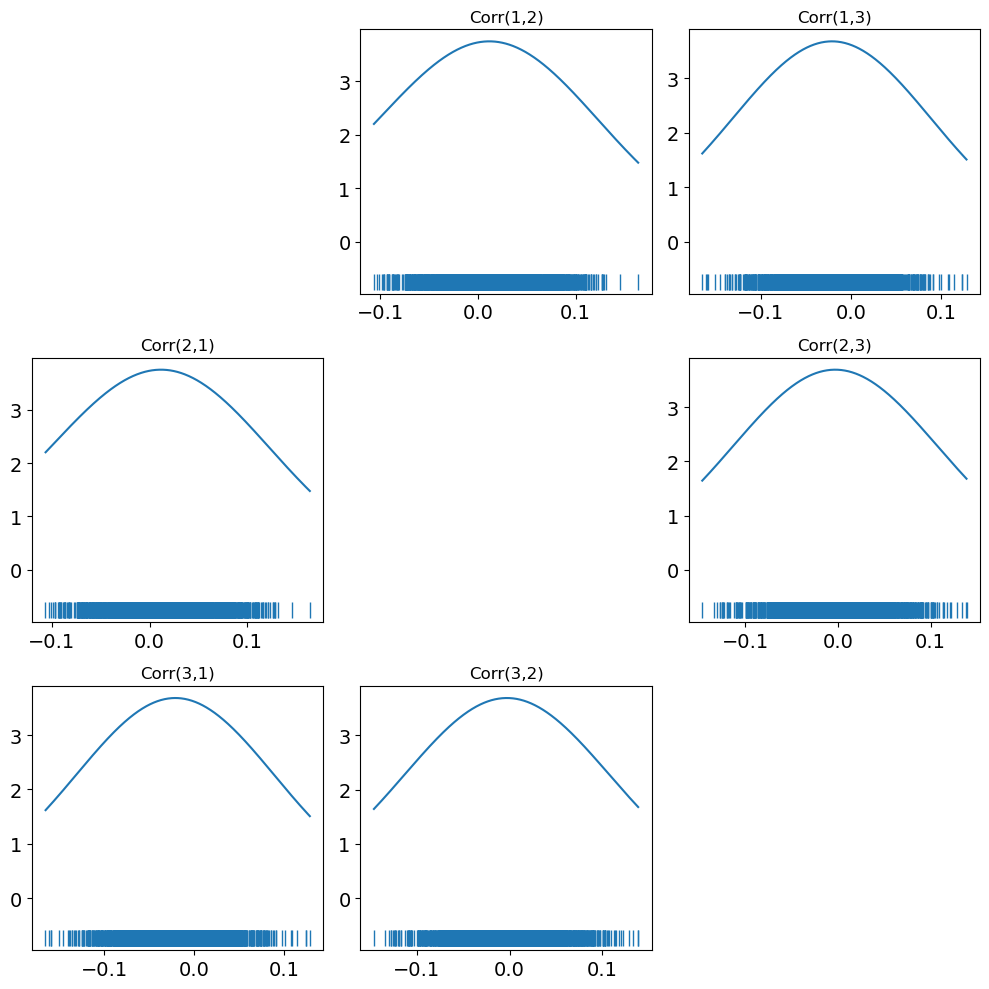

In [10]:
#Q1

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

np.random.seed(1008111151)
n_samples = 500
y = np.column_stack([
    np.random.gamma(2.0, 1.0, n_samples),
    np.random.exponential(1.0, n_samples),
    np.random.chisquare(3.0, n_samples)
])

with pm.Model() as marg1:
    p0 = pm.HalfNormal('p0', sigma=10)
    y0 = pm.Gamma('y0', alpha=p0, beta=1, observed=y[:,0])
    idata_marg1 = pm.sample(1000, tune=1000, cores=1, progressbar=False, random_seed=1008111151)

with pm.Model() as marg2:
    p1 = pm.HalfNormal('p1', sigma=10)
    y1 = pm.Exponential('y1', lam=p1, observed=y[:,1])
    idata_marg2 = pm.sample(1000, tune=1000, cores=1, progressbar=False, random_seed=1008111151)

with pm.Model() as marg3:
    p2 = pm.HalfNormal('p2', sigma=10)
    y2 = pm.ChiSquared('y2', nu=p2, observed=y[:,2])
    idata_marg3 = pm.sample(1000, tune=1000, cores=1, progressbar=False, random_seed=1008111151)

p0_mean = az.summary(idata_marg1, var_names=['p0'])['mean'].values[0]
p1_mean = az.summary(idata_marg2, var_names=['p1'])['mean'].values[0]
p2_mean = az.summary(idata_marg3, var_names=['p2'])['mean'].values[0]

u0 = stats.gamma.cdf(y[:,0], a=p0_mean, scale=1)
z0 = stats.norm.ppf(np.clip(u0, 1e-10, 1-1e-10))

u1 = stats.expon.cdf(y[:,1], scale=1/p1_mean)
z1 = stats.norm.ppf(np.clip(u1, 1e-10, 1-1e-10))

u2 = stats.chi2.cdf(y[:,2], df=p2_mean)
z2 = stats.norm.ppf(np.clip(u2, 1e-10, 1-1e-10))

Z = np.column_stack([z0, z1, z2])

print("Z contains inf/nan:", np.any(np.isinf(Z)), np.any(np.isnan(Z)))

with pm.Model() as copula_2pass:
    L, R, _ = pm.LKJCholeskyCov("R", n=3, eta=2.0, sd_dist=pm.Exponential.dist(1.0, shape=3), compute_corr=True)
    pm.MvNormal("Z_obs", mu=np.zeros(3), chol=L, observed=Z)
    idata_2pass = pm.sample(1000, tune=2000, cores=1, progressbar=False, random_seed=1008111151, target_accept=0.95)

corr_samples = idata_2pass.posterior['R_corr'].values.reshape(-1, 3, 3)
print("R_corr contains inf/nan:", np.any(np.isinf(corr_samples)), np.any(np.isnan(corr_samples)))

if not np.isfinite(corr_samples).all():
    print("Warning: Invalid correlation values detected.")
else:
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i in range(3):
        for j in range(3):
            if i != j:
                az.plot_dist(corr_samples[:, i, j], ax=axes[i, j], bw=0.1, rug=True)
                axes[i, j].set_title(f'Corr({i+1},{j+1})')
            else:
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()


A copula is a function that connects individual univariate marginal distribution functions to create a complete multivariate distribution. This allows for the separation of marginal modeling from the dependency structure. In the one-pass method, both the marginal parameters and the latent correlation are estimated simultaneously within a single model, often through deterministic transformations. In contrast, the two-pass method first estimates the marginals, transforms the data to a common scale (like Gaussian) using the inverse CDF, and then models the dependencies separately, typically with an LKJ prior on the correlation matrix, which essentially applies a Gaussian copula.

By utilizing copulas, the specification of marginal models can be decoupled from their dependency structure. This is particularly useful in multivariate generalized linear models (GLMs) with varying outcome types. In this context, each response variable can be modeled independently using the appropriate GLM, selecting the suitable link functions and distributions. Afterward, the residuals or predictions from each GLM are transformed to a common scale (such as uniform or normal scores). A copula, like a Gaussian copula with an LKJ prior on the correlation matrix, can then be used to model the joint dependence of these transformed outcomes. 

Sequential sampling (2 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [gamma]
>NUTS: [b_slab, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 73 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b_diffuse, sigma_diffuse]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


<Figure size 640x480 with 0 Axes>

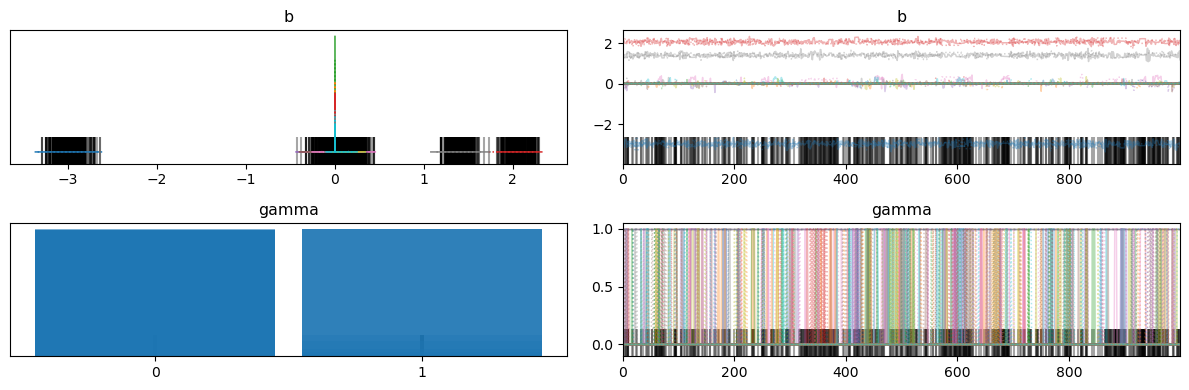

<Figure size 640x480 with 0 Axes>

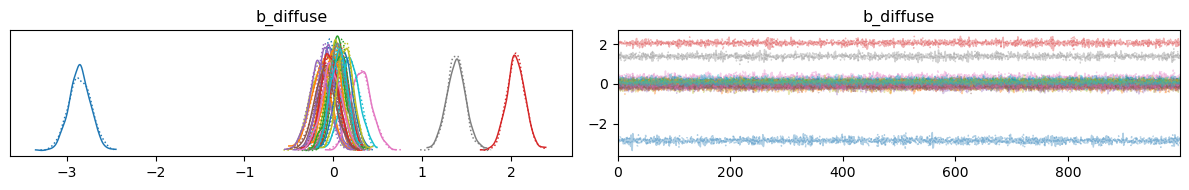

In [6]:
#Q2

import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

np.random.seed(1008111151)
n, p, m = 100, 10, 3
X = np.random.normal(0, 1, (n, p))

true_b = np.zeros((p, m))
true_b[1, 0], true_b[3, 1], true_b[5, 2] = 2.0, -3.0, 1.5
Y = X @ true_b + np.random.normal(0, 1, (n, m))

with pm.Model() as spike_slab_model:
    gamma = pm.Bernoulli('gamma', p=0.5, shape=(p, m))
    b_slab = pm.Normal('b_slab', mu=0, sigma=10, shape=(p, m))
    b = pm.Deterministic('b', gamma * b_slab)
    sigma = pm.HalfNormal('sigma', sigma=1, shape=m)
    mu = pm.math.dot(X, b)
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
    idata_spike = pm.sample(1000, tune=1000, cores=1, random_seed=1008111151)

with pm.Model() as diffuse_model:
    b_diffuse = pm.Normal('b_diffuse', mu=0, sigma=1000, shape=(p, m))
    sigma_diffuse = pm.HalfNormal('sigma_diffuse', sigma=1, shape=m)
    mu_diffuse = pm.math.dot(X, b_diffuse)
    Y_obs_diffuse = pm.Normal('Y_obs_diffuse', mu=mu_diffuse, sigma=sigma_diffuse, observed=Y)
    idata_diffuse = pm.sample(1000, tune=1000, cores=1, random_seed=1008111151)

plt.figure()
az.plot_trace(idata_spike, var_names=['b', 'gamma'])
plt.tight_layout()
plt.show()

plt.figure()
az.plot_trace(idata_diffuse, var_names=['b_diffuse'])
plt.tight_layout()
plt.show()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [tau, lam, beta_hs, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 58 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sequential sampling (2 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [gamma]
>NUTS: [b_slab, sigma_ss]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 72 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


<Figure size 640x480 with 0 Axes>

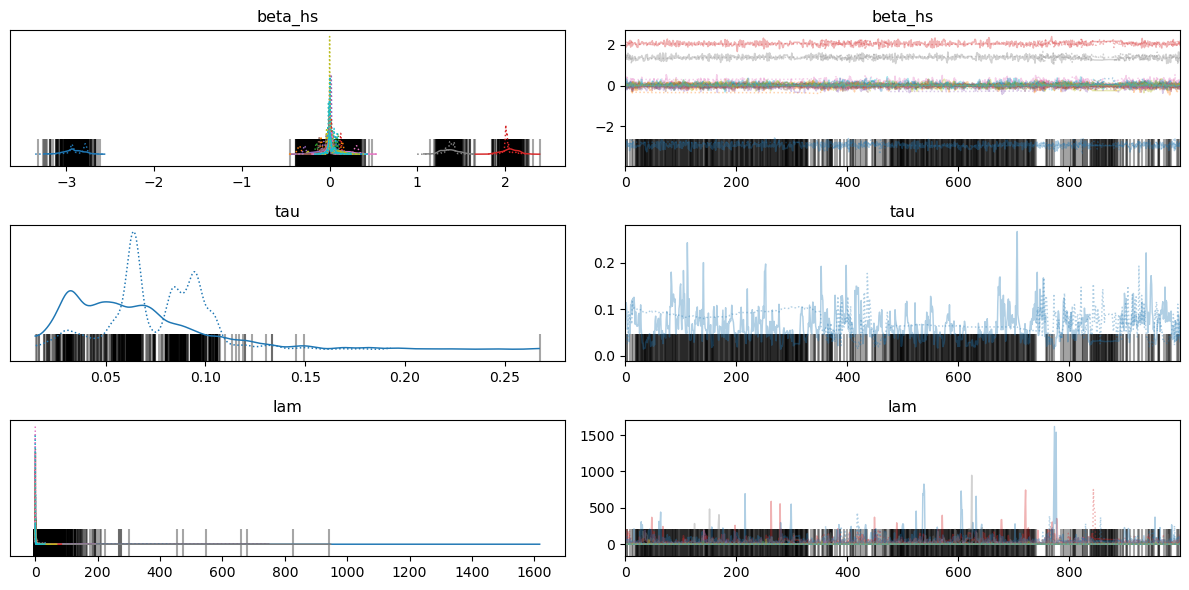

<Figure size 640x480 with 0 Axes>

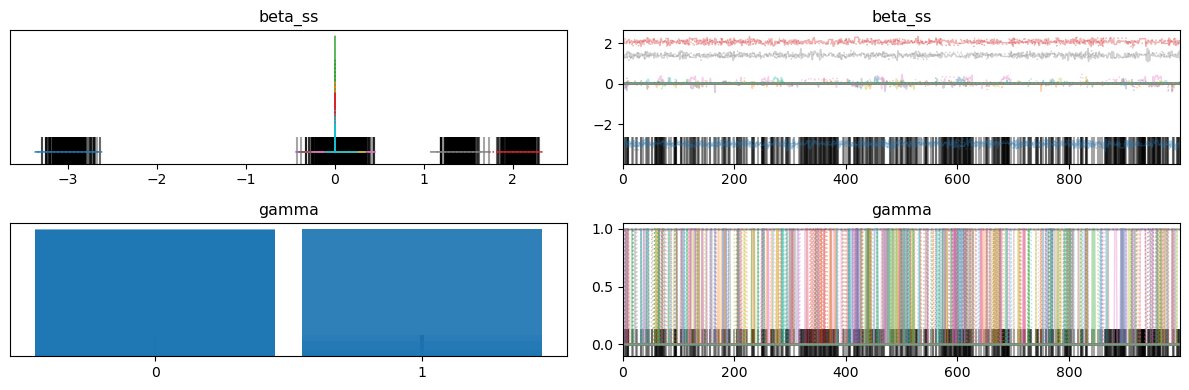

In [8]:
#Q3

import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

np.random.seed(1008111151)
n, p, m = 100, 10, 3
X = np.random.normal(0, 1, (n, p))

true_b = np.zeros((p, m))
true_b[1, 0], true_b[3, 1], true_b[5, 2] = 2.0, -3.0, 1.5
Y = X @ true_b + np.random.normal(0, 1, (n, m))

with pm.Model() as horseshoe_model:
    tau = pm.HalfCauchy('tau', beta=1.0)
    lam = pm.HalfCauchy('lam', beta=1, shape=(p, m))
    beta_hs = pm.Normal('beta_hs', mu=0, sigma=tau * lam, shape=(p, m))
    sigma = pm.HalfNormal('sigma', sigma=1, shape=m)
    mu = pm.math.dot(X, beta_hs)
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
    idata_hs = pm.sample(1000, tune=1000, cores=1, random_seed=1008111151)

with pm.Model() as spike_slab_model:
    gamma = pm.Bernoulli('gamma', p=0.5, shape=(p, m))
    b_slab = pm.Normal('b_slab', mu=0, sigma=10, shape=(p, m))
    beta_ss = pm.Deterministic('beta_ss', gamma * b_slab)
    sigma_ss = pm.HalfNormal('sigma_ss', sigma=1, shape=m)
    mu_ss = pm.math.dot(X, beta_ss)
    Y_obs_ss = pm.Normal('Y_obs_ss', mu=mu_ss, sigma=sigma_ss, observed=Y)
    idata_ss = pm.sample(1000, tune=1000, cores=1, random_seed=1008111151)

plt.figure()
az.plot_trace(idata_hs, var_names=['beta_hs', 'tau', 'lam'])
plt.tight_layout()
plt.show()

plt.figure()
az.plot_trace(idata_ss, var_names=['beta_ss', 'gamma'])
plt.tight_layout()
plt.show()